In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, Audio

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理和加载
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),                  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),               # 随机裁剪并填充
    transforms.RandomRotation(15),                      # 随机旋转 15 度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 下载并加载数据集
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 将训练集划分为训练集和验证集（90% 用于训练，10% 用于验证）
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# 定义一个简化的 VGG 模型
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 模型、损失函数和优化器
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 训练模型函数，增加验证集的损失计算
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3):
    best_loss = float('inf')
    trigger_times = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        # 调整学习率
        scheduler.step()

        # 在验证集上测试损失和准确率
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # 计算准确率
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(valloader)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1} validation loss: {val_loss:.3f}, accuracy: {accuracy:.2f}%")

        # 早停检查
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0  # 重置耐心计数器
        else:
            trigger_times += 1
            print(f"Early stopping trigger times: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("Early stopping")
                return
    print("Finished Training")


# 测试模型函数
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

# 单张图像显示函数
def imshow(img):
    img = img / 2 + 0.5  # 去归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机选择一张图像进行预测
def predict_single_image():
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    print('真实标签: ', ' '.join(f'{labels[j]}' for j in range(4)))
    imshow(torchvision.utils.make_grid(images[:4]))

    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('预测标签: ', ' '.join(f'{predicted[j]}' for j in range(4)))

# 改进后的预测函数
def predict_test_set(model, testloader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    # 存储一些正确和错误预测的样本用于显示
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():  # 禁用梯度计算，加速预测
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # 更新总数和正确预测数量
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 记录部分正确和错误的样本
            for i in range(len(labels)):
                if len(correct_samples) < 4 and predicted[i] == labels[i]:
                    correct_samples.append((inputs[i].cpu(), labels[i].cpu(), predicted[i].cpu()))
                elif len(incorrect_samples) < 4 and predicted[i] != labels[i]:
                    incorrect_samples.append((inputs[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

    # 计算准确率
    accuracy = 100 * correct / total
    print(f'Overall Accuracy on Test Set: {accuracy:.2f}%')

    # 显示部分正确预测和错误预测的样本
    print("\nCorrect Predictions:")
    for img, true_label, pred_label in correct_samples:
        print(f"True: {true_label.item()}, Predicted: {pred_label.item()}")
        imshow(img)
    
    print("\nIncorrect Predictions:")
    for img, true_label, pred_label in incorrect_samples:
        print(f"True: {true_label.item()}, Predicted: {pred_label.item()}")
        imshow(img)

def play_simple_beep():
    # 生成1秒钟的440Hz的音调
    framerate = 44100
    duration = 1
    t = np.linspace(0, duration, int(framerate * duration))
    sound = np.sin(2 * np.pi * 440 * t)  # 440Hz 为标准音调A4
    display(Audio(sound, rate=framerate, autoplay=True))

Files already downloaded and verified
Files already downloaded and verified


[1, 100] loss: 2.046
[1, 200] loss: 1.782
[1, 300] loss: 1.617
[1, 400] loss: 1.550
[1, 500] loss: 1.480
[1, 600] loss: 1.439
[1, 700] loss: 1.358
Epoch 1 validation loss: 1.461, accuracy: 44.90%
[2, 100] loss: 1.302
[2, 200] loss: 1.296
[2, 300] loss: 1.203
[2, 400] loss: 1.200
[2, 500] loss: 1.150
[2, 600] loss: 1.107
[2, 700] loss: 1.088
Epoch 2 validation loss: 1.121, accuracy: 59.32%
[3, 100] loss: 1.056
[3, 200] loss: 1.058
[3, 300] loss: 1.005
[3, 400] loss: 1.007
[3, 500] loss: 0.956
[3, 600] loss: 0.961
[3, 700] loss: 0.940
Epoch 3 validation loss: 1.025, accuracy: 64.24%
[4, 100] loss: 0.903
[4, 200] loss: 0.904
[4, 300] loss: 0.896
[4, 400] loss: 0.867
[4, 500] loss: 0.858
[4, 600] loss: 0.860
[4, 700] loss: 0.859
Epoch 4 validation loss: 1.017, accuracy: 65.50%
[5, 100] loss: 0.804
[5, 200] loss: 0.798
[5, 300] loss: 0.803
[5, 400] loss: 0.785
[5, 500] loss: 0.790
[5, 600] loss: 0.781
[5, 700] loss: 0.757
Epoch 5 validation loss: 0.820, accuracy: 72.14%
[6, 100] loss: 0.735

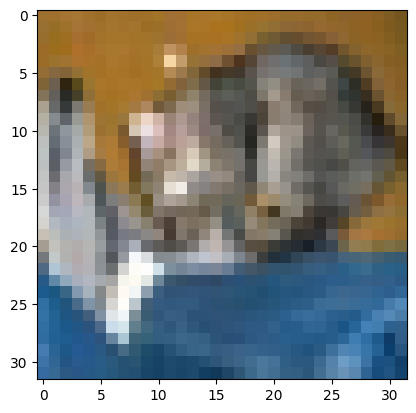

True: 8, Predicted: 8


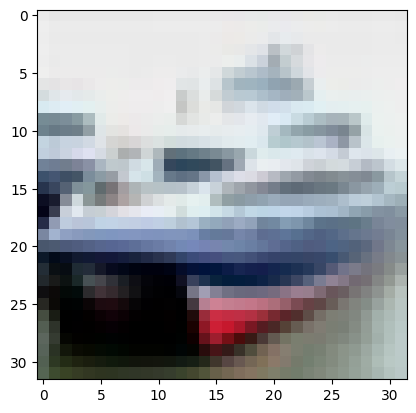

True: 6, Predicted: 6


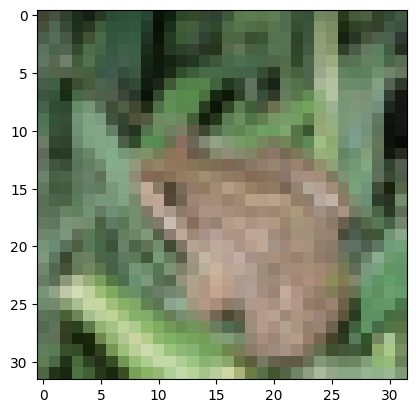

True: 6, Predicted: 6


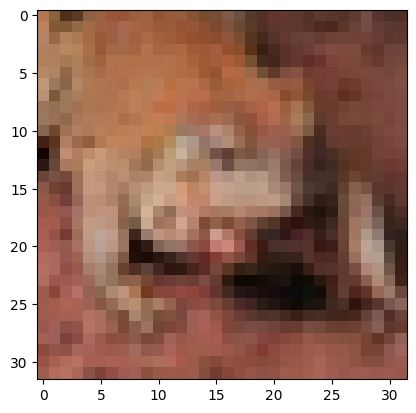


Incorrect Predictions:
True: 8, Predicted: 1


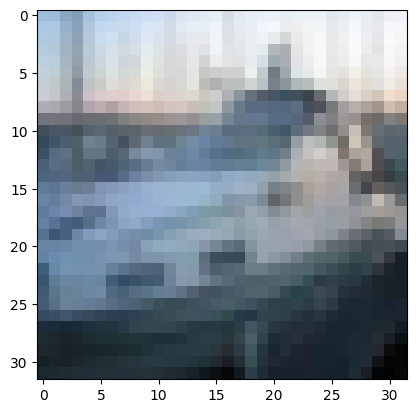

True: 0, Predicted: 8


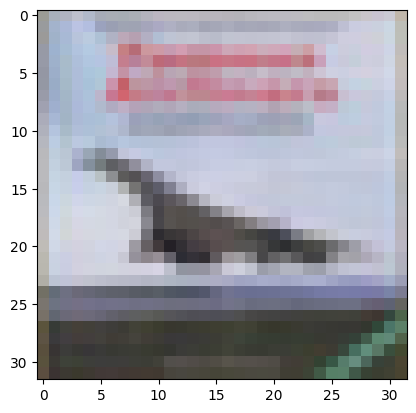

True: 4, Predicted: 2


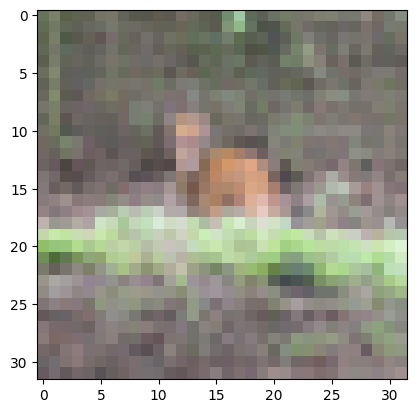

True: 5, Predicted: 2


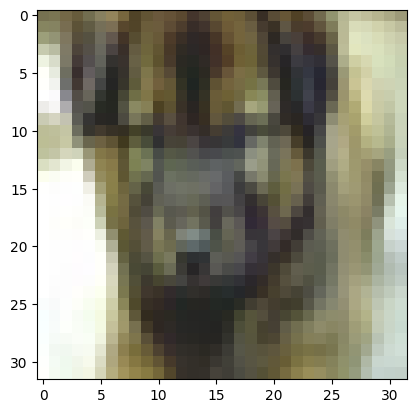

Total execution time: 911.24 seconds


In [6]:
if __name__ == '__main__':
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3)
    
    # 测试模型
    test_model(model, testloader)
    
    # 预测并保存模型
    predict_test_set(model, testloader, device)
    torch.save(model.state_dict(), 'vgg_model_1.pth')
    
    # 播放提示音
    play_simple_beep()
    
    # 记录结束时间并计算总时长
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 打印执行时间
    print(f"Total execution time: {elapsed_time:.2f} seconds")


[1, 100] loss: 0.341
[1, 200] loss: 0.344
[1, 300] loss: 0.335
[1, 400] loss: 0.364
[1, 500] loss: 0.338
[1, 600] loss: 0.373
[1, 700] loss: 0.331
Epoch 1 validation loss: 0.474, accuracy: 84.02%
[2, 100] loss: 0.338
[2, 200] loss: 0.327
[2, 300] loss: 0.324
[2, 400] loss: 0.339
[2, 500] loss: 0.321
[2, 600] loss: 0.347
[2, 700] loss: 0.341
Epoch 2 validation loss: 0.452, accuracy: 84.84%
[3, 100] loss: 0.305
[3, 200] loss: 0.330
[3, 300] loss: 0.306
[3, 400] loss: 0.346
[3, 500] loss: 0.334
[3, 600] loss: 0.328
[3, 700] loss: 0.320
Epoch 3 validation loss: 0.429, accuracy: 85.14%
[4, 100] loss: 0.313
[4, 200] loss: 0.310
[4, 300] loss: 0.330
[4, 400] loss: 0.314
[4, 500] loss: 0.327
[4, 600] loss: 0.286
[4, 700] loss: 0.321
Epoch 4 validation loss: 0.426, accuracy: 85.02%
[5, 100] loss: 0.274
[5, 200] loss: 0.270
[5, 300] loss: 0.254
[5, 400] loss: 0.249
[5, 500] loss: 0.262
[5, 600] loss: 0.257
[5, 700] loss: 0.264
Epoch 5 validation loss: 0.359, accuracy: 87.74%
[6, 100] loss: 0.235

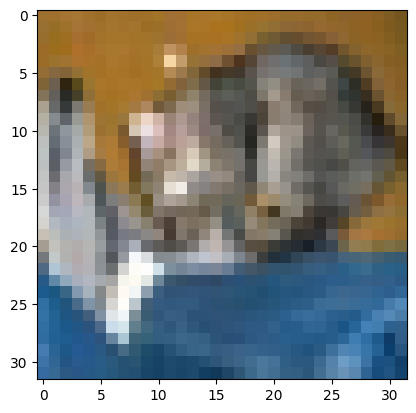

True: 8, Predicted: 8


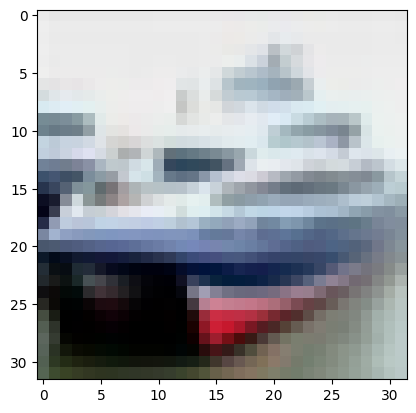

True: 8, Predicted: 8


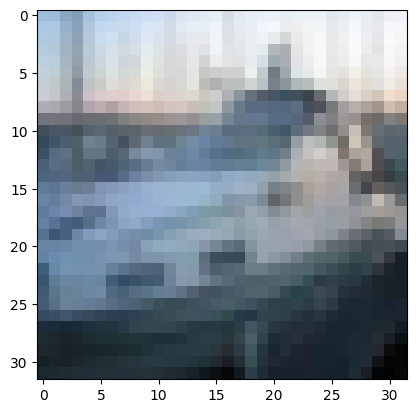

True: 0, Predicted: 0


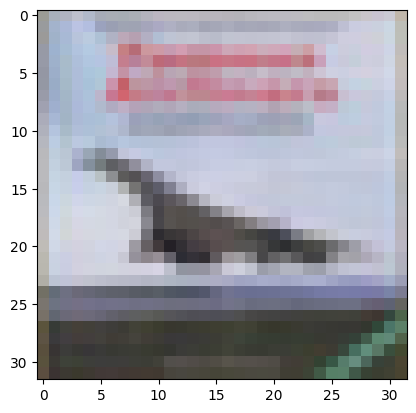


Incorrect Predictions:
True: 5, Predicted: 3


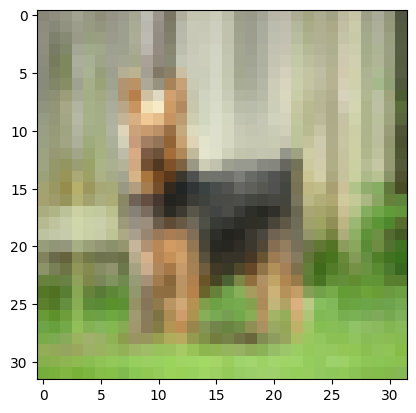

True: 2, Predicted: 3


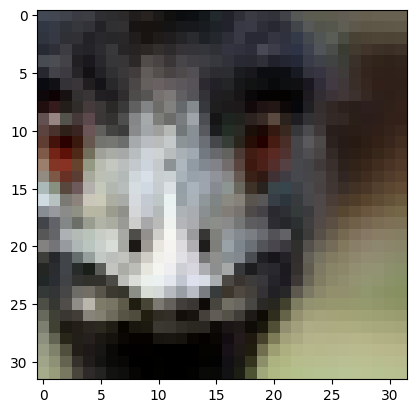

True: 0, Predicted: 2


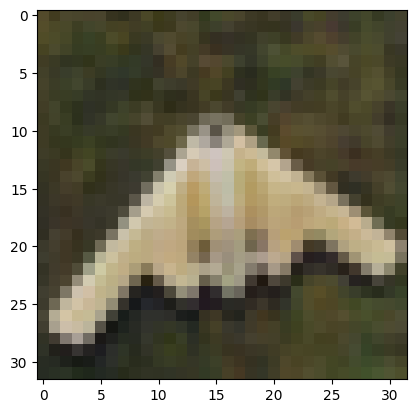

True: 4, Predicted: 5


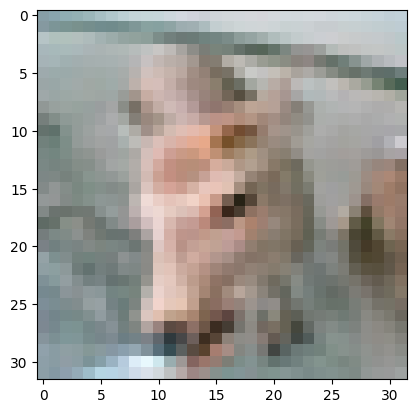

Total execution time: 637.49 seconds


In [7]:
if __name__ == '__main__':
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3)
    
    # 测试模型
    test_model(model, testloader)
    
    # 预测并保存模型
    predict_test_set(model, testloader, device)
    torch.save(model.state_dict(), 'vgg_model_2.pth')
    
    # 播放提示音
    play_simple_beep()
    
    # 记录结束时间并计算总时长
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 打印执行时间
    print(f"Total execution time: {elapsed_time:.2f} seconds")


[1, 100] loss: 0.222
[1, 200] loss: 0.205
[1, 300] loss: 0.208
[1, 400] loss: 0.212
[1, 500] loss: 0.207
[1, 600] loss: 0.206
[1, 700] loss: 0.232
Epoch 1 validation loss: 0.330, accuracy: 88.92%
[2, 100] loss: 0.207
[2, 200] loss: 0.201
[2, 300] loss: 0.194
[2, 400] loss: 0.200
[2, 500] loss: 0.201
[2, 600] loss: 0.200
[2, 700] loss: 0.195
Epoch 2 validation loss: 0.345, accuracy: 88.56%
Early stopping trigger times: 1/3
[3, 100] loss: 0.194
[3, 200] loss: 0.193
[3, 300] loss: 0.196
[3, 400] loss: 0.183
[3, 500] loss: 0.208
[3, 600] loss: 0.198
[3, 700] loss: 0.192
Epoch 3 validation loss: 0.378, accuracy: 88.32%
Early stopping trigger times: 2/3
[4, 100] loss: 0.189
[4, 200] loss: 0.166
[4, 300] loss: 0.170
[4, 400] loss: 0.160
[4, 500] loss: 0.163
[4, 600] loss: 0.164
[4, 700] loss: 0.160
Epoch 4 validation loss: 0.327, accuracy: 89.64%
[5, 100] loss: 0.151
[5, 200] loss: 0.160
[5, 300] loss: 0.158
[5, 400] loss: 0.166
[5, 500] loss: 0.165
[5, 600] loss: 0.161
[5, 700] loss: 0.154
E

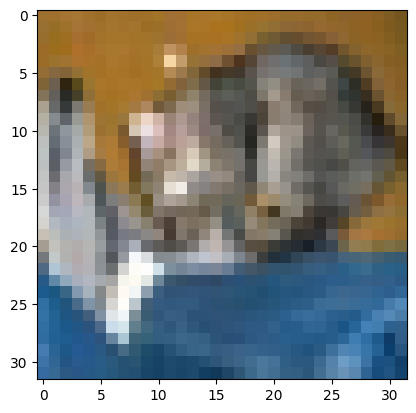

True: 8, Predicted: 8


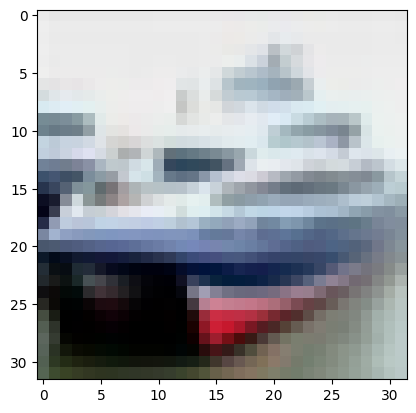

True: 8, Predicted: 8


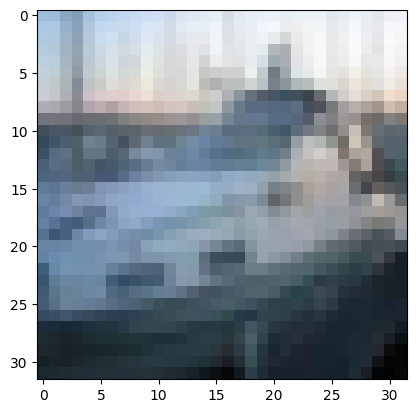

True: 0, Predicted: 0


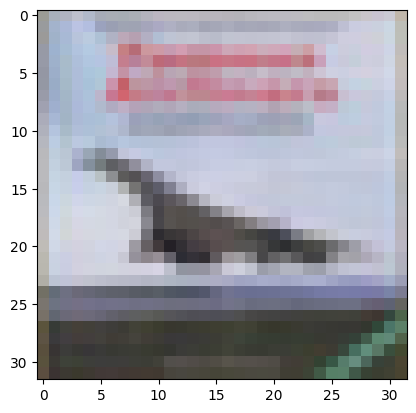


Incorrect Predictions:
True: 0, Predicted: 3


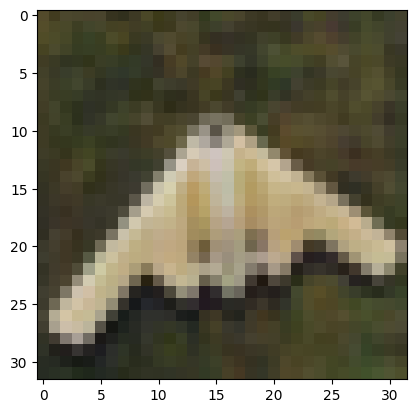

True: 4, Predicted: 5


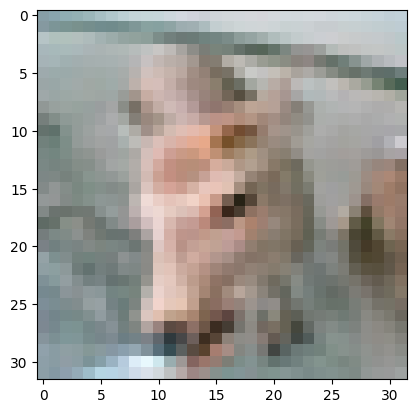

True: 6, Predicted: 3


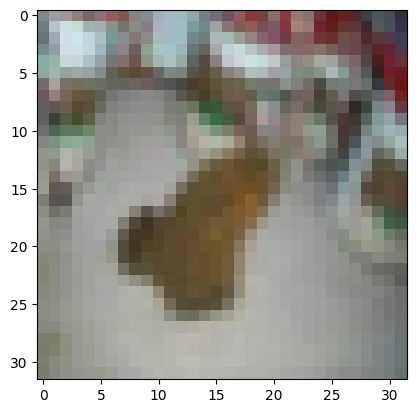

True: 3, Predicted: 5


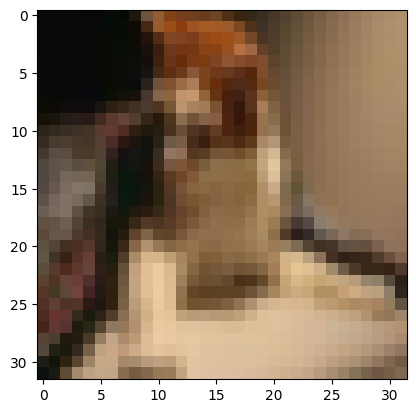

Total execution time: 555.09 seconds


In [8]:
if __name__ == '__main__':
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3)
    
    # 测试模型
    test_model(model, testloader)
    
    # 预测并保存模型
    predict_test_set(model, testloader, device)
    torch.save(model.state_dict(), 'vgg_model_3.pth')
    
    # 播放提示音
    play_simple_beep()
    
    # 记录结束时间并计算总时长
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 打印执行时间
    print(f"Total execution time: {elapsed_time:.2f} seconds")


[1, 100] loss: 0.144
[1, 200] loss: 0.148
[1, 300] loss: 0.133
[1, 400] loss: 0.140
[1, 500] loss: 0.140
[1, 600] loss: 0.148
[1, 700] loss: 0.140
Epoch 1 validation loss: 0.338, accuracy: 89.74%
[2, 100] loss: 0.121
[2, 200] loss: 0.134
[2, 300] loss: 0.142
[2, 400] loss: 0.121
[2, 500] loss: 0.141
[2, 600] loss: 0.139
[2, 700] loss: 0.155
Epoch 2 validation loss: 0.358, accuracy: 89.80%
Early stopping trigger times: 1/3
[3, 100] loss: 0.148
[3, 200] loss: 0.123
[3, 300] loss: 0.125
[3, 400] loss: 0.130
[3, 500] loss: 0.134
[3, 600] loss: 0.142
[3, 700] loss: 0.134
Epoch 3 validation loss: 0.338, accuracy: 89.78%
Early stopping trigger times: 2/3
[4, 100] loss: 0.132
[4, 200] loss: 0.125
[4, 300] loss: 0.137
[4, 400] loss: 0.134
[4, 500] loss: 0.132
[4, 600] loss: 0.135
[4, 700] loss: 0.133
Epoch 4 validation loss: 0.334, accuracy: 89.90%
[5, 100] loss: 0.113
[5, 200] loss: 0.126
[5, 300] loss: 0.116
[5, 400] loss: 0.108
[5, 500] loss: 0.105
[5, 600] loss: 0.113
[5, 700] loss: 0.116
E

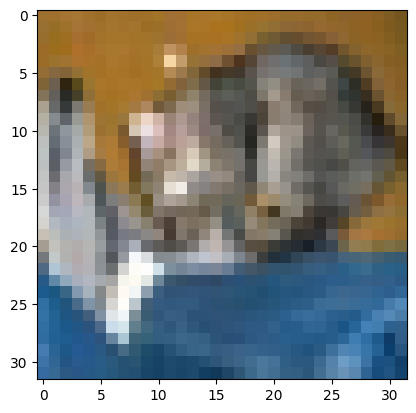

True: 8, Predicted: 8


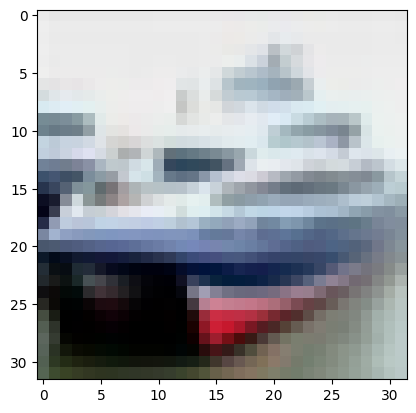

True: 8, Predicted: 8


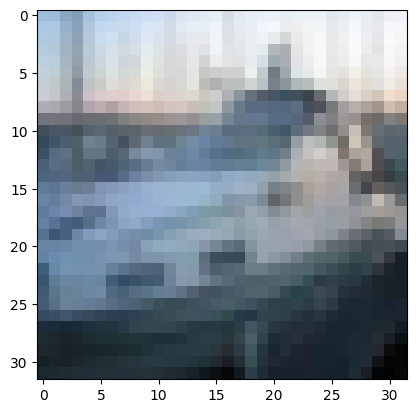

True: 0, Predicted: 0


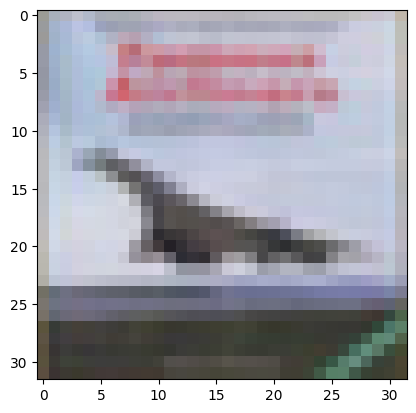


Incorrect Predictions:
True: 1, Predicted: 9


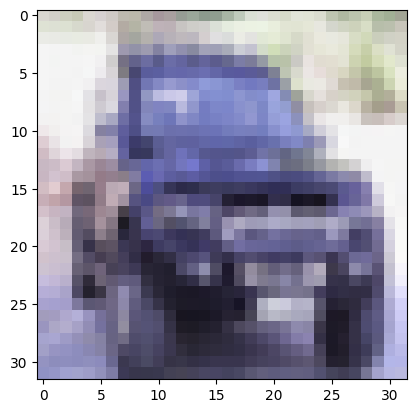

True: 9, Predicted: 0


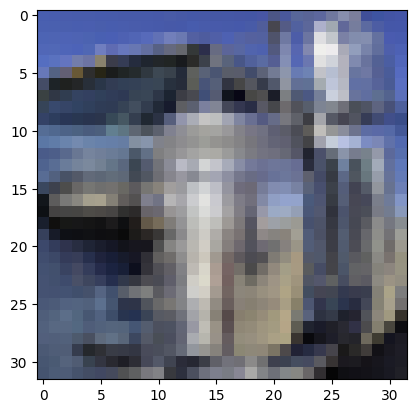

True: 0, Predicted: 3


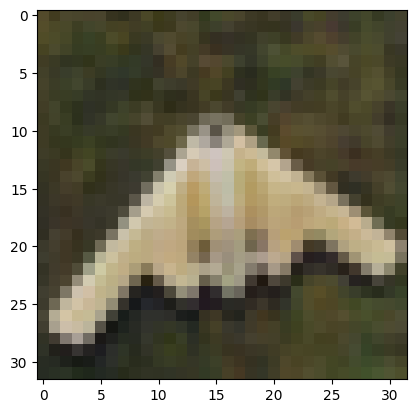

True: 4, Predicted: 5


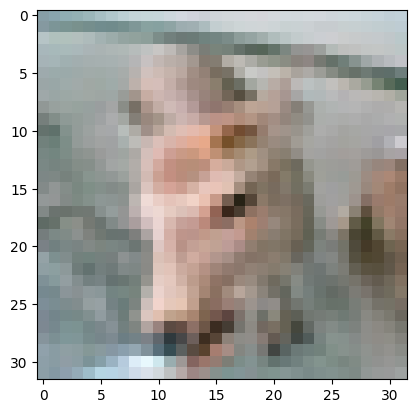

Total execution time: 621.44 seconds


In [9]:
if __name__ == '__main__':
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3)
    
    # 测试模型
    test_model(model, testloader)
    
    # 预测并保存模型
    predict_test_set(model, testloader, device)
    torch.save(model.state_dict(), 'vgg_model_4.pth')
    
    # 播放提示音
    play_simple_beep()
    
    # 记录结束时间并计算总时长
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 打印执行时间
    print(f"Total execution time: {elapsed_time:.2f} seconds")


In [3]:
import torch
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

# 加载训练好的模型
model = VGG()  # 使用与训练时相同的模型结构
model.load_state_dict(torch.load('vgg_model_4.pth'))
model.eval()  # 设置为评估模式
model.to('cpu')  # 将模型移到 CPU 上进行处理

# 设置文件路径
output_qonnx_filename = 'vgg_model_ready.onnx'

# 假设您的输入大小为 (1, 3, 32, 32)（例如 CIFAR-10 图像数据的形状）
input_shape = (1, 3, 32, 32)

# 创建一个 QuantTensor 输入来标记导出过程中的双极输入
import numpy as np
input_data = np.random.randint(0, 1, size=input_shape).astype(np.float32)
input_data = 2 * input_data - 1  # 转换为双极格式 [-1, +1]
input_tensor = torch.from_numpy(input_data)

# 导出为 QONNX 格式
export_qonnx(model, export_path=output_qonnx_filename, input_t=input_tensor)

# 清理生成的 ONNX 文件
qonnx_cleanup(output_qonnx_filename, out_file=output_qonnx_filename)

# 使用 ModelWrapper 包装 QONNX 模型
model_wrapper = ModelWrapper(output_qonnx_filename)

# 明确设置输入的数据类型（确保导出过程中不会丢失）
model_wrapper.set_tensor_datatype(model_wrapper.graph.input[0].name, DataType["BIPOLAR"])

# 将 QONNX 转换为 FINN-ONNX 格式
model_wrapper = model_wrapper.transform(ConvertQONNXtoFINN())

# 保存 FINN-ONNX 格式的模型
finn_onnx_filename = 'vgg_model_finn.onnx'
model_wrapper.save(finn_onnx_filename)

print(f"Model successfully converted to FINN-ONNX format and saved as {finn_onnx_filename}")


C:\Users\Lem17\AppData\Local\Temp\ipykernel_16428\1472818589.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg_model_4.pth'))


ModuleNotFoundError: Installation of onnx and onnxoptimizer is required.

In [4]:
pip install onnx onnxoptimizer

     ---------------------------------------- 0.0/18.5 MB ? eta -:--:--
     ---- ----------------------------------- 2.1/18.5 MB 13.1 MB/s eta 0:00:02
     --------- ------------------------------ 4.2/18.5 MB 11.5 MB/s eta 0:00:02
     ------------- -------------------------- 6.3/18.5 MB 11.0 MB/s eta 0:00:02
     ------------------ --------------------- 8.4/18.5 MB 11.1 MB/s eta 0:00:01
     ---------------------- ---------------- 10.5/18.5 MB 10.4 MB/s eta 0:00:01
     -------------------------- ------------ 12.6/18.5 MB 10.5 MB/s eta 0:00:01
     ------------------------------- ------- 14.7/18.5 MB 10.7 MB/s eta 0:00:01
     ----------------------------------- --- 16.8/18.5 MB 10.3 MB/s eta 0:00:01
     --------------------------------------  18.4/18.5 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 18.5/18.5 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to res

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [8 lines of output]
  fatal: not a git repository (or any of the parent directories): .git
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Lem17\AppData\Local\Temp\pip-install-jr5jn4nb\onnxoptimizer_d0bdcc90d2864ee38f72a0052dd83c3a\setup.py", line 76, in <module>
      assert CMAKE, 'Could not find "cmake" executable!'
             ^^^^^
  AssertionError: Could not find "cmake" executable!
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
